In [43]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sqlite3
import seaborn as sns

from py_utilities.__init__ import print_corr_matrix

db_folder = "data/raw_data/"
db_filename = "database.sqlite"

# Construct the relative file path
db_path = os.path.join(db_folder, db_filename)
con = sqlite3.connect(db_path)


In [57]:
# Some plot styling preferences
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 14}

# Set styles for plots
qualitative_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

palette = 'crest'
style = 'darkgrid'

font = {'family': 'serif', 'size': 12}

# Set seaborn palette and style
sns.set(palette=palette, style=style, font=font)
plt.rc('font', **font)

In [44]:
# Check the available tables
tables = pd.read_sql("""
    SELECT * FROM sqlite_master 
    WHERE TYPE = 'table' """,con)

for row in tables["sql"]:
    print(row)

CREATE TABLE runs (
        run_at text not null,
        max_rowid integer not null,
        reviews_added integer not null
    )
CREATE TABLE podcasts (
        podcast_id text primary key,
        itunes_id integer not null,
        slug text not null,
        itunes_url text not null,
        title text not null
    )
CREATE TABLE categories (
        podcast_id text not null,
        category text not null
    )
CREATE TABLE reviews (
        podcast_id text not null,
        title text not null,
        content text not null,
        rating integer not null,
        author_id text not null,
        created_at text not null
    )


We are going to investigate which podcasts are the most popular and which ones have the highest number of reviews, and their respective categories.

In [45]:
# Check the number of podcasts

num_podcasts = pd.read_sql("""
SELECT
   COUNT(*) AS total_podcasts 
FROM
   podcasts;""", con)

num_podcasts.head()

,total_podcasts
0,110024


In [46]:
# Check the number of reviews

num_reviews = pd.read_sql("""
SELECT
   COUNT(*) AS total_reviews 
FROM
   reviews;""", con)

num_reviews.head()

,total_reviews
0,2067529


We can assume that podcasts with the highest number of reviews are also the most popular ones. But this does not always correlate with a higher rating, so let's check this assumption and see if it holds. We are also interested in the categories of the podcasts, so let's first get the number of reviews for each category.

In [77]:
top_10_podcasts = pd.read_sql("""
SELECT
    p.title,
    COUNT(r.podcast_id) AS review_count,
    AVG(r.rating) AS avg_rating,
    c.category
FROM
    podcasts p
JOIN
    reviews r
    ON p.podcast_id = r.podcast_id
JOIN
    categories c
    ON p.podcast_id = c.podcast_id
GROUP BY
    p.title
ORDER BY
    review_count DESC
""", con)

top_10_podcasts.head(10)

,title,review_count,avg_rating,category
0,Crime Junkie,33104,4.274982,true-crime
1,Wow in the World,29094,4.776243,education
2,My Favorite Murder with Karen Kilgariff and Ge...,21350,3.605714,comedy
3,Know Your Aura with Mystic Michaela,20236,4.983594,education
4,Don't Keep Your Day Job,19728,4.940085,business
5,Bachelor Happy Hour,17972,3.567550,society-culture
6,Zane and Heath: Unfiltered,16248,4.815854,comedy
7,And That's Why We Drink,15392,4.505198,comedy
8,Be There in Five,15170,4.898154,comedy
9,Daebak Show w/ Eric Nam,14915,4.984244,music


In [78]:
top_10 = top_10_podcasts.nlargest(10, 'review_count')
top_10

,title,review_count,avg_rating,category
0,Crime Junkie,33104,4.274982,true-crime
1,Wow in the World,29094,4.776243,education
2,My Favorite Murder with Karen Kilgariff and Ge...,21350,3.605714,comedy
3,Know Your Aura with Mystic Michaela,20236,4.983594,education
4,Don't Keep Your Day Job,19728,4.940085,business
5,Bachelor Happy Hour,17972,3.567550,society-culture
6,Zane and Heath: Unfiltered,16248,4.815854,comedy
7,And That's Why We Drink,15392,4.505198,comedy
8,Be There in Five,15170,4.898154,comedy
9,Daebak Show w/ Eric Nam,14915,4.984244,music


Pearson Correlation Coefficient: -0.17921849761327957
Spearman Correlation Coefficient: -0.43030303030303024
Kendall Correlation Coefficient: -0.28888888888888886


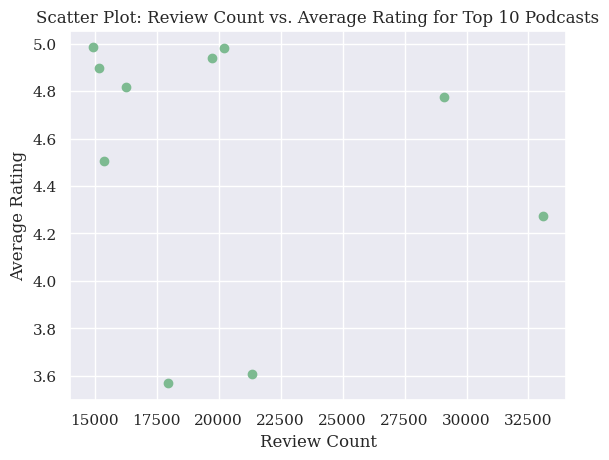

In [79]:

# Create a scatter plot
plt.scatter(top_10['review_count'], top_10['avg_rating'])
plt.xlabel('Review Count')
plt.ylabel('Average Rating')
plt.title('Scatter Plot: Review Count vs. Average Rating for Top 10 Podcasts')

# Calculate correlation coefficients
pearson_corr = top_10['review_count'].corr(top_10['avg_rating'], method='pearson')
spearman_corr = top_10['review_count'].corr(top_10['avg_rating'], method='spearman')
kendall_corr = top_10['review_count'].corr(top_10['avg_rating'], method='kendall')

# Display correlation coefficients
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman Correlation Coefficient: {spearman_corr}")
print(f"Kendall Correlation Coefficient: {kendall_corr}")

# Show the plot
plt.show()

In [80]:
print_corr_matrix(top_10,method='spearman')

,review_count,avg_rating
review_count,1.00,-0.43
avg_rating,-0.43,1.00


There are some interesting results.

Let's see which is the highest rated podcast. This might obtain very interesting results as we have just seen, so let's make sure that the number of reviews is substantial to confirm it's a popular one. 

We will opt for a minimum of 5000 reviews. 

In [52]:
top_rated_podcast = pd.read_sql("""
SELECT
   p.title,
   AVG(r.rating) AS avg_rating,
   COUNT(r.podcast_id) as review_count 
FROM
   podcasts p 
   LEFT JOIN
      reviews r 
      ON p.podcast_id = r.podcast_id 
GROUP BY
   p.title 
HAVING
   COUNT(r.podcast_id) > 5000 
ORDER BY
   avg_rating DESC LIMIT 1;
""", con)   

top_rated_podcast

,title,avg_rating,review_count
0,Know Your Aura with Mystic Michaela,4.983594,5059


We can also check the most active reviewer

In [53]:
top_reviewer = pd.read_sql("""
SELECT
   author_id,
   COUNT(*) AS review_count,
   RANK () OVER (
ORDER BY
   COUNT(*) DESC) AS rank 
FROM
   reviews 
GROUP BY
   author_id 
ORDER BY
   review_count DESC LIMIT 10;
-- Top 10 most active reviewers
""", con)

top_reviewer

,author_id,review_count,rank
0,D3307ADEFFA285C,615,1
1,791F376ACA3C08D,615,1
2,96A3F0358E7808D,475,3
3,04C3B6DEFE22FB1,433,4
4,8858ED4249110B6,399,5
5,7F9EA8B1A449BFC,361,6
6,4B25015E4D7A1DA,341,7
7,B20DB44F45DB97A,323,8
8,A52EBC918BC19D1,322,9
9,C02C514DAA9D885,314,10


Let's check the various categories in which podcasts are present, to see if there is a correlation with the number of categories and their number of reviews.

In [54]:
categories_count = pd.read_sql("""
SELECT
   p.title,
   COUNT(r.podcast_id) AS review_count,
   COUNT(DISTINCT c.category) AS category_count 
FROM
   podcasts p 
   JOIN
      categories c 
      ON p.podcast_id = c.podcast_id 
   JOIN
      reviews r 
      ON p.podcast_id = r.podcast_id 
GROUP BY
   p.title 
ORDER BY
   category_count DESC LIMIT 15;
-- Top 10 with most diverse categories
""", con)

categories_count

,title,review_count,category_count
0,No Title,51,14
1,Theatre of the Mind,1062,9
2,We Made It,36,8
3,Pursue Excellence,40,8
4,FrazerRice.Com,48,8
5,Evolve,132,8
6,Everything Under The Sun,15,8
7,Beyond Retirement,400,8
8,Where There's Smoke,1688,7
9,We Do Hard Things,28,7


Now let's say we are interested in calculating the time gap between reviews, and want to get the top 10 for longest and shortest gap.

In [55]:
longest_review_gap = pd.read_sql("""
WITH ReviewGaps AS 
(
   SELECT
      r.podcast_id,
      p.title,
      r.created_at,
      LAG(r.created_at) OVER (PARTITION BY r.podcast_id 
   ORDER BY
      r.created_at) AS prev_review_time 
   FROM
      reviews r 
      JOIN
         podcasts p 
         ON r.podcast_id = p.podcast_id 
)
SELECT
   podcast_id,
   title,
   AVG(julianday(created_at) - julianday(prev_review_time)) AS avg_gap_days,
   (
      SELECT
         AVG(rating) 
      FROM
         reviews r 
      WHERE
         r.podcast_id = ReviewGaps.podcast_id
   )
   AS avg_rating 
FROM
   ReviewGaps 
WHERE
   prev_review_time IS NOT NULL 
GROUP BY
   podcast_id,
   title 
ORDER BY
   avg_gap_days
LIMIT 10;
-- Top 10 podcasts with the longest average gap between reviews
""", con)

longest_review_gap

,podcast_id,title,avg_gap_days,avg_rating
0,e30c701bb5825ac002f5e23886b8b9f6,Indie Living Room,0.000000,5.0
1,e3b08ab63c9f28a5cf8a3d08d2220a99,Under The Covers,0.000000,5.0
2,ecd6da0b428af4b3ad9c19def79b61a1,Insights and Updates - The Literacy Bug,0.000000,4.0
3,f75c45a294bee499d088ccc4215eef5a,"Hey Mum, what’re you watching?",0.000000,5.0
4,f7ced17d4648cd4d6b34bf36470fd4b3,Los Indecisos,0.000012,5.0
5,c6a1bfc49f3e626216b5e352e0297f59,"Walking by Faith Podcast: Where marriage, mini...",0.000023,5.0
6,fd0db592170bb10ce4efe43ad2bc25f1,QUESTIONED AUTHORITY,0.000023,5.0
7,eafc00673398c394edf25b2eba89662e,Conspiracy Talk,0.000035,5.0
8,d65c6dbc653d549d858a60280b82e8b9,Cougar Nation Sports Weekly,0.000046,5.0
9,cdf3337d36a826ac3a2d9efb331daf9c,Particle,0.000058,5.0


In [56]:
shortest_review_gap = pd.read_sql("""
WITH ReviewGaps AS 
(
   SELECT
      r.podcast_id,
      p.title,
      r.created_at,
      LAG(r.created_at) OVER (PARTITION BY r.podcast_id 
   ORDER BY
      r.created_at) AS prev_review_time 
   FROM
      reviews r 
      JOIN
         podcasts p 
         ON r.podcast_id = p.podcast_id 
)
SELECT
   podcast_id,
   title,
   AVG(julianday(created_at) - julianday(prev_review_time)) AS avg_gap_days,
   (
      SELECT
         AVG(rating) 
      FROM
         reviews r 
      WHERE
         r.podcast_id = ReviewGaps.podcast_id
   )
   AS avg_rating 
FROM
   ReviewGaps 
WHERE
   prev_review_time IS NOT NULL 
GROUP BY
   podcast_id,
   title 
ORDER BY
   avg_gap_days DESC LIMIT 10;
-- Top 10 podcasts with the longest average gap between reviews
""", con)

shortest_review_gap

,podcast_id,title,avg_gap_days,avg_rating
0,f6d781483e7fa40d43aa527254927663,Dr. Alan Cairns on SermonAudio,5290.944780,5.0
1,fdc13d932e5e7560aa213a16c5331295,Remix podcast from Magnatune.com,4964.536586,1.5
2,b66a47cc1c53e9c360b1e8ee1080d99e,Texas Corners Bible Church,4602.742731,5.0
3,a4987765263442032f293dcdf93e488c,Crime Fighters,4487.748958,3.5
4,c4a4ce8be06ec5ed358e4d97b5470c49,Country Music Cast,4325.018681,3.0
5,e7b09c856c458dc08573ea806f155a8b,Teacher's Pet Podcast - Training Pets & Pet Ob...,4219.153692,5.0
6,a7b02498b80812303f29944bd777a0b1,Health Report - Full program podcast,4215.330220,5.0
7,dcd9480725027d7fac9e8c24d286a397,House Junkee Podcast,4149.584294,5.0
8,a295413f283c7d163cfe72c962c79ef9,Indie Rock Baseball,4135.929850,5.0
9,e6b9ecf4cc71e1d98c62992d21257d0c,Mathematical Moments from the American Mathema...,4116.464630,4.5
